# Project Exoplane Background Removal

### Initialization

In [1]:
# Loading libs
from astropy.io import fits #need to install the "astropy" package

# system lib
import numpy as np
import os
import cv2
import copy
import re
from glob import glob
import imageio
import subprocess
import datetime
import collections
import random
import time
import shutil

from astro_vae_package import astro_plot
from astro_vae_package import utils

# machine learning lib
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from IPython import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.utils.data import Dataset

# plot lib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib.backends.backend_pdf import PdfPages
import PIL
from PIL import Image
from scipy.ndimage import zoom

In [2]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda


### Load fits no disk which is picked by Fang's algorithm.

In [3]:
# Ring region, where there is only the control ring (i.e., no disk signal) when mask = 1
mask_ring = fits.getdata('assets\\mask_ring.fits')
mask_ring = utils.crop_central_squared_image(mask_ring)

# Regions to plot, ignore the mask = 0 regions
mask_plot = fits.getdata('assets\\mask_plot.fits')
mask_plot = utils.crop_central_squared_image(mask_plot)

# Regions of input, drop data where the mask = 0
mask_input = fits.getdata('assets\\mask_input.fits')
mask_input = utils.crop_central_squared_image(mask_input)

# Regions to impute, ignore the mask = 0 regions
mask_impute = fits.getdata('assets\\mask_impute.fits')
mask_impute = utils.crop_central_squared_image(mask_impute)

<Figure size 600x400 with 0 Axes>

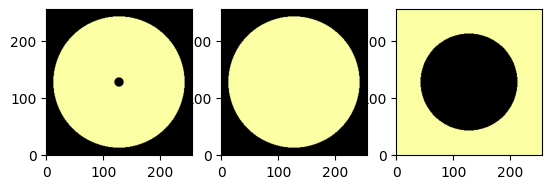

In [4]:
# Masked target image

fig = plt.figure(figsize = (6, 4))
fig, axs = plt.subplots(1, 3)
astro_plot.subplot_log_image(axs[0], mask_plot, vmax=1)
astro_plot.subplot_log_image(axs[1], mask_impute, vmax=1)
astro_plot.subplot_log_image(axs[2], mask_input, vmax=1)

In [5]:
dataset_all_path = 'POLARIS_Exoplanet_Data\\dataset_all'
dataset_ref_path = 'POLARIS_Exoplanet_Data\\dataset_reference'
vae_raw_imgs = []
vae_input_imgs = []
vae_target_imgs = []
vae_log_raw_imgs = []
vae_log_input_imgs = []
vae_log_target_imgs = []
vae_norm_raw_imgs = []
vae_norm_input_imgs = []
vae_norm_target_imgs = []
file_num = 0
total = 0

debug_mode = True
for root, dirs, files in os.walk(dataset_ref_path):
    for file in files:
        if re.match(r'^[^.].*_frames.fits$', file, False):
            imgs = fits.getdata(os.path.join(root, file))
            file_num += 1
            if debug_mode:
                img = imgs[0]
                img = utils.crop_central_squared_image(img)
                log_img = utils.get_log_img(img)
                norm_img = utils.normalize_img(log_img)
                vae_raw_imgs.append(img)
                vae_input_imgs.append(img * mask_input)
                vae_target_imgs.append(img * mask_impute)
                vae_log_raw_imgs.append(log_img)
                vae_log_input_imgs.append(log_img * mask_input)
                vae_log_target_imgs.append(log_img * mask_impute)
                vae_norm_raw_imgs.append(norm_img)
                vae_norm_input_imgs.append(norm_img * mask_input)
                vae_norm_target_imgs.append(norm_img * mask_impute)
                total += 1
            else:
                count = 0
                for img in imgs:
                    if count > 3:
                        continue
                    img = crop_central_squared_image(img)
                    log_img = get_log_img(img)
                    norm_img = normalize_img(log_img)
                    vae_raw_imgs.append(img)
                    vae_input_imgs.append(img * mask_input)
                    vae_target_imgs.append(img * mask_impute)
                    vae_log_raw_imgs.append(log_img)
                    vae_log_input_imgs.append(log_img * mask_input)
                    vae_log_target_imgs.append(log_img * mask_impute)
                    vae_norm_raw_imgs.append(norm_img)
                    vae_norm_input_imgs.append(norm_img * mask_input)
                    vae_norm_target_imgs.append(norm_img * mask_impute)
                    total += 1
                    count += 1

(array([5.1000e+01, 6.2000e+01, 8.0000e+01, 1.0400e+02, 1.3000e+02,
        1.3300e+02, 2.1700e+02, 2.4000e+02, 3.4300e+02, 4.2200e+02,
        5.8000e+02, 6.5300e+02, 8.6400e+02, 1.0980e+03, 1.2750e+03,
        1.5730e+03, 1.8450e+03, 2.0910e+03, 2.1750e+03, 2.7462e+04,
        2.3330e+03, 2.4560e+03, 2.7030e+03, 2.7530e+03, 2.4040e+03,
        1.8280e+03, 1.4160e+03, 1.2680e+03, 1.0330e+03, 1.0000e+03,
        9.1300e+02, 7.5300e+02, 6.0300e+02, 4.9200e+02, 3.4500e+02,
        2.9600e+02, 2.5000e+02, 2.2500e+02, 1.9500e+02, 1.5100e+02,
        1.4500e+02, 1.4400e+02, 1.2900e+02, 1.0800e+02, 6.7000e+01,
        5.6000e+01, 3.7000e+01, 2.3000e+01, 6.0000e+00, 6.0000e+00]),
 array([-2.29305935, -2.17270391, -2.05234848, -1.93199305, -1.81163761,
        -1.69128218, -1.57092674, -1.45057131, -1.33021587, -1.20986044,
        -1.089505  , -0.96914957, -0.84879414, -0.7284387 , -0.60808327,
        -0.48772783, -0.3673724 , -0.24701696, -0.12666153, -0.0063061 ,
         0.11404934,  0.23

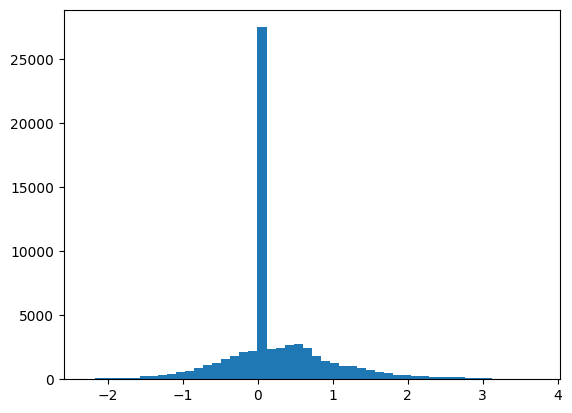

In [6]:
x = vae_norm_target_imgs[0]
plt.hist(x.reshape(-1), bins=50)

<Figure size 600x600 with 0 Axes>

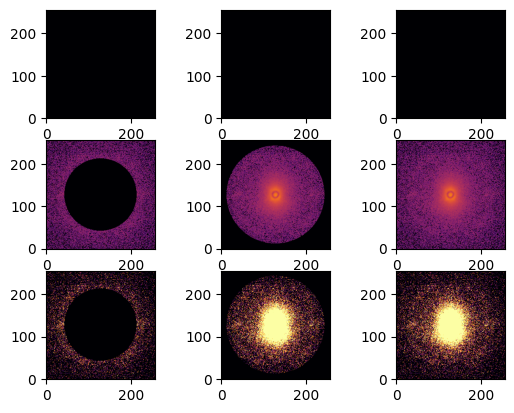

In [7]:
fig = plt.figure(figsize = (6, 6))
fig, axs = plt.subplots(3, 3)
idx = 10
astro_plot.subplot_log_image(axs[0, 0], vae_input_imgs[idx], 1e4)
astro_plot.subplot_log_image(axs[0, 1], vae_target_imgs[idx], 1e4)
astro_plot.subplot_log_image(axs[0, 2], vae_raw_imgs[idx], 1e4)
astro_plot.subplot_linear_image(axs[1, 0], vae_log_input_imgs[idx], 0, 10)
astro_plot.subplot_linear_image(axs[1, 1], vae_log_target_imgs[idx], 0, 10)
astro_plot.subplot_linear_image(axs[1, 2], vae_log_raw_imgs[idx], 0, 10)
astro_plot.subplot_linear_image(axs[2, 0], vae_norm_input_imgs[idx], vmin = 0, vmax = 1)
astro_plot.subplot_linear_image(axs[2, 1], vae_norm_target_imgs[idx], vmin = 0, vmax = 1)
astro_plot.subplot_linear_image(axs[2, 2], vae_norm_raw_imgs[idx], vmin = 0, vmax = 1)

### VAE Modeling

### Training and Data validation

In [15]:
# =======================
# Training
# =======================
from astro_vae_package import dataset
from astro_vae_package import vae_model
from astro_vae_package import training

dataset = dataset.CreateTrainingImagesDataset(vae_norm_input_imgs, vae_norm_target_imgs)
val_fraction = 0.1
val_size = int(len(dataset) * val_fraction)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = vae_model.AstroConvVae(in_channel=1, latent_dim=16).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

loss_hist = training.train_vae(vae, train_loader, val_loader, optimizer, device,
                      epochs=150, kl_max=1e-4, kl_warmup_epochs=20,
                      print_every=5, save_every=10, boundary_weight = 0.8, circle_radius = 80, boundary_width = 5,
                      checkpoint_dir='vae_checkpoints\\VAE_result_fit')

Epoch 5 | Train Total Loss: 2.7754 | Recon Loss: 0.1996 | KL Loss: 160.4828 | KL Weight: 0.0000Pattern Loss: 2.4671
Epoch 5 | Val Total Loss: 2.1156 | Val Recon Loss: 0.1730 | Val KL Loss: 144.1793| Val Boundary Loss: 0.1054| Val Pattern Loss: 1.8548
Epoch 10 | Train Total Loss: 2.6854 | Recon Loss: 0.1729 | KL Loss: 104.5895 | KL Weight: 0.0001Pattern Loss: 2.4077
Epoch 10 | Val Total Loss: 2.1097 | Val Recon Loss: 0.1797 | Val KL Loss: 82.6223| Val Boundary Loss: 0.1148| Val Pattern Loss: 1.8340
Epoch 15 | Train Total Loss: 2.6306 | Recon Loss: 0.1556 | KL Loss: 83.3076 | KL Weight: 0.0001Pattern Loss: 2.3750
Epoch 15 | Val Total Loss: 2.0405 | Val Recon Loss: 0.1498 | Val KL Loss: 77.1532| Val Boundary Loss: 0.0947| Val Pattern Loss: 1.8092
Epoch 20 | Train Total Loss: 2.6060 | Recon Loss: 0.1486 | KL Loss: 74.7331 | KL Weight: 0.0001Pattern Loss: 2.3521
Epoch 20 | Val Total Loss: 2.0619 | Val Recon Loss: 0.1678 | Val KL Loss: 77.9633| Val Boundary Loss: 0.1009| Val Pattern Loss: 1.

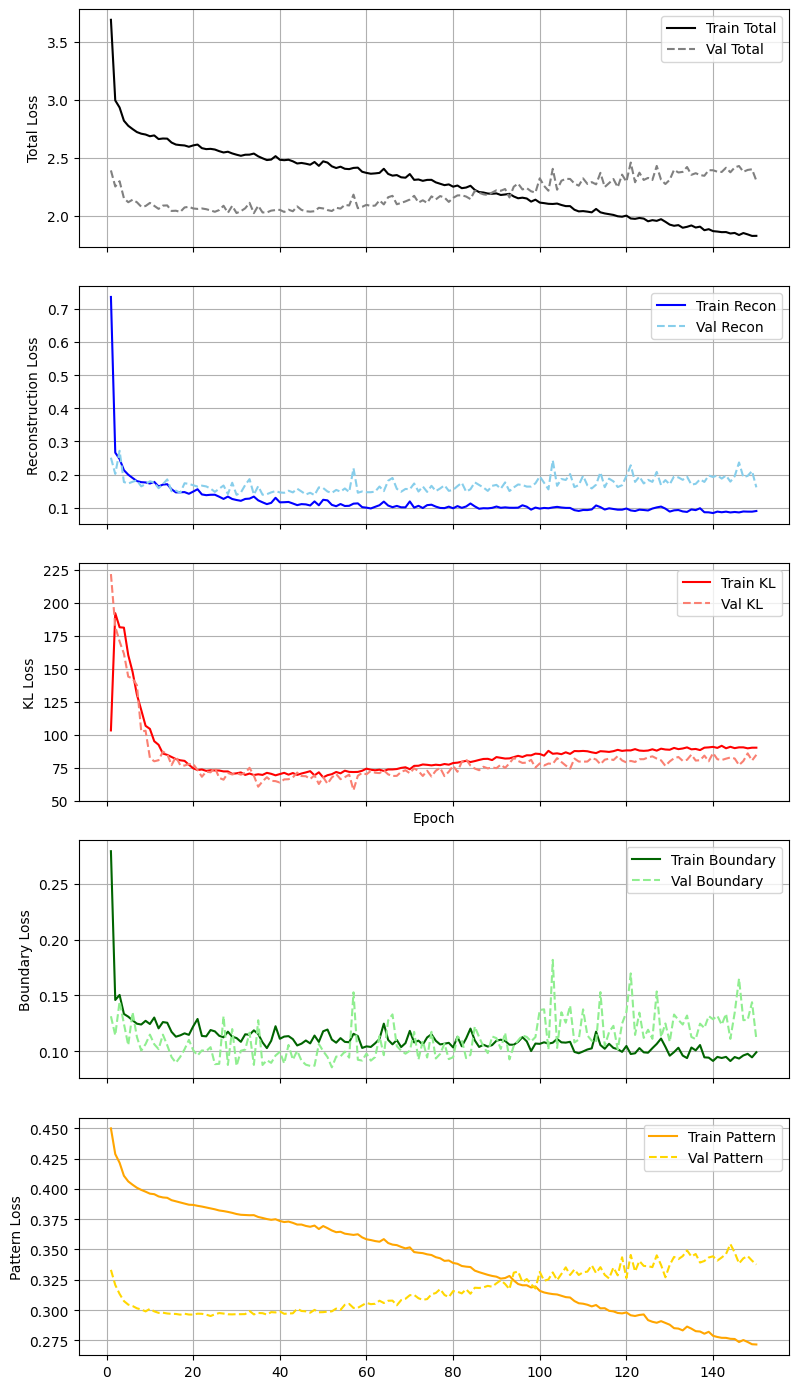

In [16]:
# Plot losses
from astro_vae_package import training
training.plot_train_val_loss(loss_hist)

In [17]:
torch.save(vae, 'vae_checkpoints\\vae_model_v1_full')
torch.save(vae.state_dict(), 'vae_checkpoints\\vae_model_v1_weight')

### Plot Result

<Figure size 1000x800 with 0 Axes>

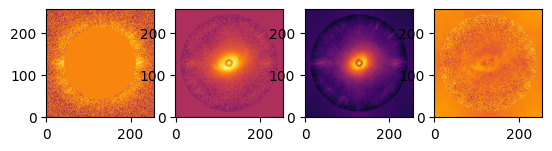

In [18]:
test_input, test_target = train_dataset[1]
test_input = test_input.to(device)
model_output = vae(test_input)
test_impute = model_output[0]
test_encode_vec = model_output[1]
test_input = test_input.cpu().detach().numpy()
test_impute = test_impute.cpu().detach().numpy()
test_target = test_target.cpu().detach().numpy()
test_diff = test_target - test_impute 
fig = plt.figure(figsize = (10, 8))
fig, axs = plt.subplots(1, 4)
vmin = -2
vmax = 5
astro_plot.subplot_linear_image(axs[0], test_input[0], np.min(test_input[0]), np.max(test_input[0]))
astro_plot.subplot_linear_image(axs[1], test_target[0], np.min(test_target[0]), np.max(test_target[0]))
astro_plot.subplot_linear_image(axs[2], test_impute[0][0], np.min(test_impute[0][0]), np.max(test_impute[0][0]))
astro_plot.subplot_linear_image(axs[3], test_diff[0][0], np.min(test_diff[0][0]), np.max(test_diff[0][0]))

<Figure size 1000x800 with 0 Axes>

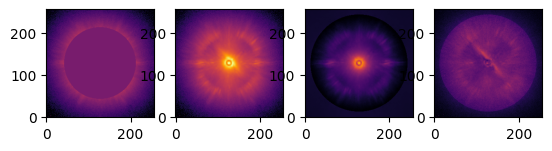

In [19]:
disk_file_path = 'POLARIS_Exoplanet_Data\\dataset_all\\HD_129590\\2022\\20220331_1648790171\\HD_129590_2022-04-01_frames.fits'
# disk_file_path = 'plot_examples\\V351_Ori\\preprocessed\\V_V351_Ori_2021-01-21_cube_left_frames.fits'
disk_imgs = fits.getdata(disk_file_path)  #with disk
img = disk_imgs[0]
img = utils.crop_central_squared_image(img)
log_img = utils.get_log_img(img)
norm_img = utils.normalize_img(log_img)
masked_input_img = norm_img * mask_input
test_input = torch.tensor(masked_input_img, dtype=torch.float32).reshape((1, 1, 256, 256))
test_input = test_input.to(device)
model_output = vae(test_input)
test_impute = model_output[0]
test_encode_vec = model_output[1]
test_input = test_input.cpu()
test_impute = test_impute.cpu().detach().numpy()
test_diff = (norm_img - test_impute)
fig = plt.figure(figsize = (10, 8))
fig, axs = plt.subplots(1, 4)
vmin = -2
vmax = 4
astro_plot.subplot_linear_image(axs[0], masked_input_img, vmin, vmax)
astro_plot.subplot_linear_image(axs[1], norm_img, vmin, vmax)
astro_plot.subplot_linear_image(axs[2], test_impute[0][0], 0, 5)
astro_plot.subplot_linear_image(axs[3], np.exp(test_diff[0][0]), 0, 3)

In [20]:
imputed_img = test_impute[0][0]
subtracted_img = np.exp(test_diff[0][0])
fits.writeto('assets\\HD_129590_2022-04-01_vae_subtracted.fits', subtracted_img, overwrite=True)
fits.writeto('assets\\HD_129590_2022-04-01_vae_imputed_bg.fits', imputed_img, overwrite=True)

### Plot Result

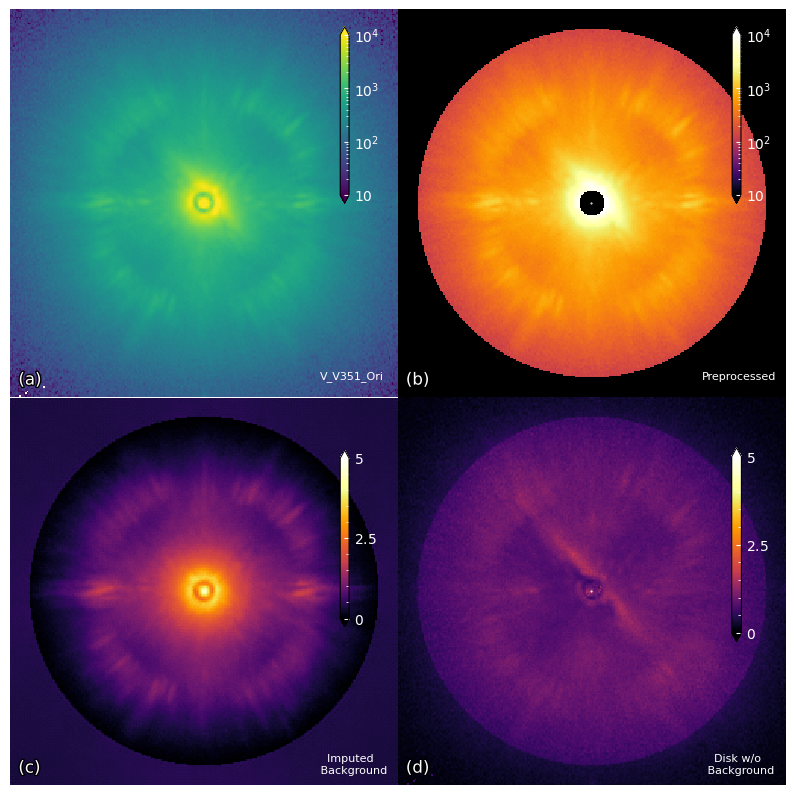

In [21]:
from astro_vae_package import astro_plot
astro_plot.plot_vae_processed_image([img, img * mask_plot, imputed_img, subtracted_img])